In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import copy
import plotly.express as px
import pandas as pd

from utils import (singles, xywh2xyxy, xywhRead, relax, cropLarge)

In [2]:
testDir = 'test'
trainDir = 'train'

singleBBox = singles(trainDir)
np.random.shuffle(singleBBox)

In [12]:
bigImg = cropLarge(cv2.imread('large_images_no_seals/2V3A7581.JPG'), size=600)

for impath in singleBBox:
    txtpath = impath + '.txt'
    impath += '.JPG'
    impath = 'test.JPG'
    txtpath = 'test.txt'
    img = cv2.imread(impath)
    # cv2.imwrite(os.path.join('singleObjects', os.path.basename(impath)), img)
    w, h = img.shape[1], img.shape[0]

    orig_xywh = xywhRead(txtpath)
    relax_xywh = relax(copy.copy(orig_xywh))

    orig_xyxy = xywh2xyxy(orig_xywh)
    relax_xyxy = xywh2xyxy(relax_xywh)
    # converting to pixel coordinates
    orig_xyxy[:, [0, 2]] = orig_xyxy[:, [0, 2]] * w
    orig_xyxy[:, [1, 3]] = orig_xyxy[:, [1, 3]] * h
    orig_xyxy = orig_xyxy.round().astype(int).squeeze()

    relax_xyxy[:, [0, 2]] = relax_xyxy[:, [0, 2]] * w
    relax_xyxy[:, [1, 3]] = relax_xyxy[:, [1, 3]] * h
    relax_xyxy = relax_xyxy.round().astype(int).squeeze()

    orig_xmin, orig_ymin = orig_xyxy[0], orig_xyxy[1]
    orig_xmax, orig_ymax = orig_xyxy[2], orig_xyxy[3]

    relax_xmin, relax_ymin = relax_xyxy[0], relax_xyxy[1]
    relax_xmax, relax_ymax = relax_xyxy[2], relax_xyxy[3]

    smallCrop = img[relax_ymin:relax_ymax, relax_xmin:relax_xmax, :]
    imgMask = np.zeros(img.shape[:-1], dtype=np.uint8)
    imgMask[relax_ymin:relax_ymax, relax_xmin:relax_xmax] = 255
    mask = imgMask[relax_ymin:relax_ymax, relax_xmin:relax_xmax]
    # mask = cv2.resize(mask, (0,0), fx=0.4, fy=0.4)
    # img = cv2.resize(img, (0,0), fx=0.4, fy=0.4)
    for _ in range(4):
        dstImg = next(bigImg).astype(np.uint8)
    out = cv2.seamlessClone(img, dstImg, imgMask, (300, 300), cv2.MIXED_CLONE)
    cv2.imwrite('output/out.jpg', out)
    break
    



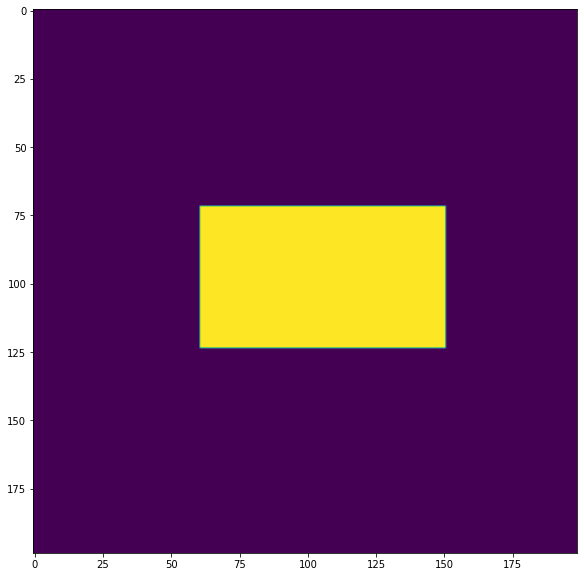

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(imgMask)


Let's try to cluster cropped seal images

In [4]:
# cv2.imwrite('output/out1.jpg', out)
# plt.imshow(smallCrop)

In python opencv __HSV__
 has the following range correspondingly
__[0-179, 0-255, 0-255]__

In [56]:
HSV = {"img": [], "h": [], "s": [], "v": []}
for impath in singleBBox:
    txtpath = impath + '.txt'
    impath += '.JPG'
    img = cv2.imread(impath)
    img = cv2.GaussianBlur(img, (7, 7), 3)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    w, h = img.shape[1], img.shape[0]

    xywh = xywhRead(txtpath)
    xyxy = xywh2xyxy(xywh)

    # converting to pixel coordinates
    xyxy[:, [0, 2]] = xyxy[:, [0, 2]] * w
    xyxy[:, [1, 3]] = xyxy[:, [1, 3]] * h
    xyxy = xyxy.round().astype(int).squeeze()
    xmin, ymin = xyxy[0], xyxy[1]
    xmax, ymax = xyxy[2], xyxy[3]

    hue = hsv[:, :, 0].astype(np.float32)
    sat = hsv[:, :, 1].astype(np.float32)
    val = hsv[:, :, 2].astype(np.float32)
    hue[ymin:ymax, xmin:xmax] = np.nan
    sat[ymin:ymax, xmin:xmax] = np.nan
    val[ymin:ymax, xmin:xmax] = np.nan
    HSV["h"].append(np.nanmean(hue))
    HSV["s"].append(np.nanmean(sat))
    HSV["v"].append(np.nanmean(val))
    HSV["img"].append(impath)
    # greens.append((np.nanmean(hue), np.nanmean(sat), np.nanmean(val)))
    # if 55 < np.nanmean(hue) < 80 and np.nanmean(val) > 200 and np.nanmean(sat) < 100:
    #     greens.append(impath)

In [57]:
from sklearn.cluster import KMeans

In [72]:
df = pd.DataFrame(np.array([*HSV.values()]).T)
hsvArray = df.iloc[:, 1::].astype(np.float32)

In [74]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(hsvArray)
clusters = kmeans.labels_

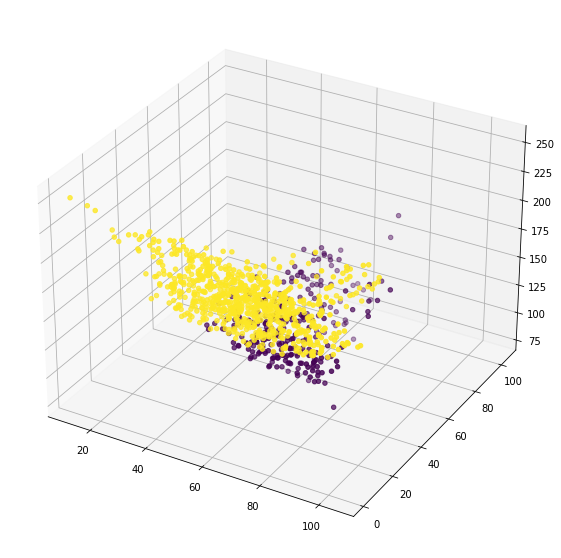

In [75]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(HSV["h"], HSV["s"], HSV["v"], c=clusters)
plt.show()

In [94]:
im0 = df.iloc[clusters == 0, :]
im1 = df.iloc[clusters == 1, :]

In [98]:
for im in im1[0]:
    i = cv2.imread(im)
    cv2.imwrite(os.path.join("1", os.path.basename(im)), i)


In [99]:
# fig = px.scatter_3d(df["h, s, v, clusters"], x='h', y='s', z='v',
#               color='clusters')
# fig.show()

Crop smaller images from annotated large images. \
Recalculate coordinates on small images

In [2]:
xywh = xywhRead('large_imgs/annotations/1V1A8820.txt')
xyxy = xywh2xyxy(xywh)
img = cv2.imread('large_imgs/1V1A8820.JPG')
h, w = img.shape[:-1]

# converting to pixel coordinates
xyxy[:, [0, 2]] = xyxy[:, [0, 2]] * w
xyxy[:, [1, 3]] = xyxy[:, [1, 3]] * h
xyxy = xyxy.round().astype(int).squeeze()
xmin, ymin = xyxy[0], xyxy[1]
xmax, ymax = xyxy[2], xyxy[3]

In [3]:
cv2.rectangle(img, 
plt.figure(figsize=(20,20))
plt.imshow(img)

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - rectangle() missing required argument 'pt1' (pos 2)
>  - rectangle() missing required argument 'pt1' (pos 2)
>  - rectangle() missing required argument 'rec' (pos 2)
>  - rectangle() missing required argument 'rec' (pos 2)
